In [1]:
import matplotlib.pyplot as plt
import serial
import numpy as np
from numpy.random import randn
from numpy import dot, linalg, eye, array
import matplotlib.animation as animation
from time import time, localtime
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta, kappa, beta
from sympy import symbols, Matrix, Function, diff, preview
import scipy
import serial
import math
from scipy.spatial.transform import Rotation

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

from quat_update import QuaterUpdate

In [2]:
def plot_path(x0, y0, z0, x1=None, y1=None, z1=None, title='3D Trajectory of Tag'):
    plt.ion()
    # Create a new figure and a 3D Axes object
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D line showing the path
    ax.plot(x0, y0, z0, label='Measured path', color='blue', marker='o', markersize=1, linewidth=0.5)

    if x1 is not None and y1 is not None and z1 is not None:
        ax.plot(x1, y1, z1, label='UKF Path', color='red', marker='o',  markersize=1, linewidth=0.5)

    # Label axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add a legend and a title
    ax.legend()
    ax.set_title(title)

    # Show the plot
    plt.show()

def plot_1d_path(x0, x1, title='1D Trajectory of Tag'):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111)

    ax.plot(x0, label='Measured path', color='blue', marker='o', markersize=1.3, linewidth=1)
    ax.plot(x1, label='UKF Path', color='red', marker='o',  markersize=1.3, linewidth=1)

    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')

    plt.show()



### UKF setup


$$
\mathcal{X} = \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \\ z \\ \dot{z} \\ q_0 \\ q_1 \\ q_2 \\ q_3  \end{bmatrix} \quad [10 \times 1],

\quad

u = \begin{bmatrix} \omega_x \\ \omega_y \\ \omega_z \\ a_x \\ a_y \\ a_z\end{bmatrix} \quad [6 \times 1],

\quad

z = \begin{bmatrix} x \\ y \\ z \\ m_x \\ m_y \\ m_z \\ a_x \\ a_y \\ a_z \end{bmatrix} \quad [9 \times 1]
$$


In [3]:
# Setting gain=0 for madgwick to stop gryo drift correction step in this algorithm
# Instead, we correct gyro drfit in update step of our UKF
gain = 0

# Quaterion helper object for quaternion helper operations
quater_helper = QuaterUpdate(gain)
g = 9.81

def fx(sigma, dt, u):
    x, vx, y, vy, z, vz, q0, q1, q2, q3 = sigma.ravel()
    wx, wy, wz, ax, ay, az = u.ravel()

    pos = np.array([x, y, z])
    vel = np.array([vx, vy, vz])
    acc = np.array([ax, ay, az])
    quat = np.array([q0, q1, q2, q3])

    # normalizing wouldn't hurt
    quat /= np.linalg.norm(quat)

    # Get rotation matrix constructed from our current quaternion
    R = quater_helper.quat_to_rot(quat)
    init_g = -g * np.array([
        [0.01],
        [0.01],
        [0.99]
    ])

    # Get acc in global frame
    # R @ acc is the global acceleration
    acc_global = R @ acc + init_g.ravel()
    
    # update position, and velocity in global frame
    new_pos = pos + vel * dt + 0.5 * acc_global * (dt**2)
    new_vel = vel + acc_global * dt

    # update quaternion
    # mag given as zero since our gain = 0 for this madgwick quaternion update
    new_quat = quater_helper.update_quat(
        quat=quat,
        gyro=np.array([wx, wy, wz]),
        acc=np.array([ax, ay, az]),
        mag=np.array([0.0, 0.0, 0.0]),
        dt=dt
    )

    # print("Shapes: ", new_pos.shape, new_vel.shape, new_quat.shape)
    return np.array([
        new_pos[0], new_vel[0],
        new_pos[1], new_vel[1],
        new_pos[2], new_vel[2],
        new_quat[0], new_quat[1], new_quat[2], new_quat[3]
    ])


def hx(sigma, acc, init_mag):
    # speed is not used in this step, thus underlined
    x, _, y, _, z, _, q0, q1, q2, q3 = sigma.ravel()

    # rotation matrix using predicted quaternion from predict step
    R = quater_helper.quat_to_rot(np.array([q0, q1, q2, q3]))
    
    # Following is only useful when the object is almost stationary
    # Project the gravity vector in local frame 
    # if it is not close to stationary, proceed with measured acceleration
    # to skip the update step
    acc_norm = np.linalg.norm(acc)
    pred_g = acc / acc_norm

    # TODO: Do we only check if acc_norm is close to stationary?
    if acc_norm >= (0.98 * g) and acc_norm <= (1.02 * g):
    # if True:
        init_g = g * np.array([
            [0.01],
            [0.01],
            [0.99]
        ])
        pred_g = R.T @ init_g
        pred_g /= np.linalg.norm(pred_g)
        
    # predicted magnetic field
    # he initial magnetic field in global frame
    # init_mag comes from NED global frame in normalized form
    pred_mag = R.T @ init_mag

    return np.array([x, y, z, *pred_mag.ravel(), *pred_g.ravel()])

def get_Q_noise(dt, var, qvar):
    Q_noise = Q_discrete_white_noise(
        dim=2, 
        dt=dt, 
        var=var,
        block_size=5
    )
    Q_noise[6: , 6: ] = 0
    for i in range(6, 10):
        Q_noise[i][i] = qvar
    return Q_noise


def get_Q_noise_calibrated(dt, Q0, q):
    # For gyro to quat noise calculation
    q0, q1, q2, q3 = q.ravel()
    
    # 10x6 matrix for control to state covariance transition
    G = np.array([
        [0, 0, 0, 0.5 * (dt ** 2), 0, 0], # only ax affects x position
        [0, 0, 0, dt, 0, 0], # only ax affects x velocity
        [0, 0, 0, 0, 0.5 * (dt ** 2), 0], # only ax affects x position
        [0, 0, 0, 0, dt, 0],
        [0, 0, 0, 0, 0, 0.5 * (dt ** 2)],
        [0, 0, 0, 0, 0, dt],
        [-q1, -q2, -q3, 0, 0, 0],
        [q0, -q3, q2, 0, 0, 0],
        [q3, q0, -q1, 0, 0, 0],
        [-q2, q1, q0, 0, 0, 0],
    ])

    # returning 10x10 noise for process transition
    return G @ Q0 @ G.T




### Units
- The unit of position is [m], 
- the unit of acceleration is [m/s^2], 
- the unit of gyroscope is [degree per sec],
- the unit of magnetic is [uT].


### Variance measurements from data
Following is calculated from the stationary data of the tag using "stational_imu_measurement.txt" file.
- x Var: 3.5140257117854756e-06
- y Var: 0.00011835920792969562
- z Var: 0.0012443314179301729
- a_x Var: 1.731042754494596e-05
- a_y Var: 1.5012931084431404e-05
- a_z Var: 1.9031043823852673e-05
- w_x Var: 3.4186534199823104e-05
- w_y Var: 2.1289448355532706e-05
- w_z Var: 2.09939873262611e-05
- m_x Var: 0.43205725237431103
- m_y Var: 0.5172368921273852
- m_z Var: 0.36627446633534255

### Measurment Noise Calculation
Measurement noise can be simply diagnol matrix with the variance of the measurements.

$$

z = \begin{bmatrix} x \\ y \\ z \\ m_x \\ m_y \\ m_z \\ a_x \\ a_y \\ a_z \end{bmatrix} \quad [9 \times 1]

\quad

R =
\begin{bmatrix}
var(x) & 0 & 0 & ...\\ 
0 & var(y) & 0 & ...\\ 
0 & 0 & var(z) & ...\\ 
\vdots & \vdots & \vdots
\end{bmatrix} \quad [9 \times 9]
$$
### Control Noise calculation

$$
u = \begin{bmatrix} \omega_x \\ \omega_y \\ \omega_z \\ a_x \\ a_y \\ a_z\end{bmatrix} \quad [6 \times 1]
\quad
\text{has covariance }

Q_0 = \begin{bmatrix} \sum_w & 0 \\ 0 & \sum_a \end{bmatrix} \quad [6 \times 6]
$$

where each $\sum$ is diagonal matrix with variance of the control inputs. Our final noise will be 

$$
Q = GQ_0G^T \quad [10 \times 10]
$$
where G is Translational matrix from control to state $X$, basically describing how our control input $u$ influence the state.

$$
G =
\begin{bmatrix}
0 & 0 & 0 & 0.5 \Delta t^2 & 0 & 0 \\ 
0 & 0 & 0 & \Delta t & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0.5 \Delta t^2 & 0 \\ 
0 & 0 & 0 & 0 & \Delta t & 0 \\ 
0 & 0 & 0 & 0 & 0 & 0.5 \Delta t^2 \\ 
0 & 0 & 0 & 0 & 0 & \Delta t \\ 
-q_1 & -q_2 & -q_3 & 0 & 0 & 0 \\ 
q_0 & -q_3 & q_2 & 0 & 0 & 0 \\ 
q_3 & q_0 & -q_1 & 0 & 0 & 0 \\ 
-q_2 & q_1 & q_0 & 0 & 0 & 0
\end{bmatrix}
$$

Reading file:  rotate_and_moving2_imu_measurement.txt
Initial Quaternion:  [-0.24089687  0.22965223  0.70932466 -0.62135906]
Initial state:  [-0.          0.         -0.          0.         -0.          0.
 -0.24089687  0.22965223  0.70932466 -0.62135906]


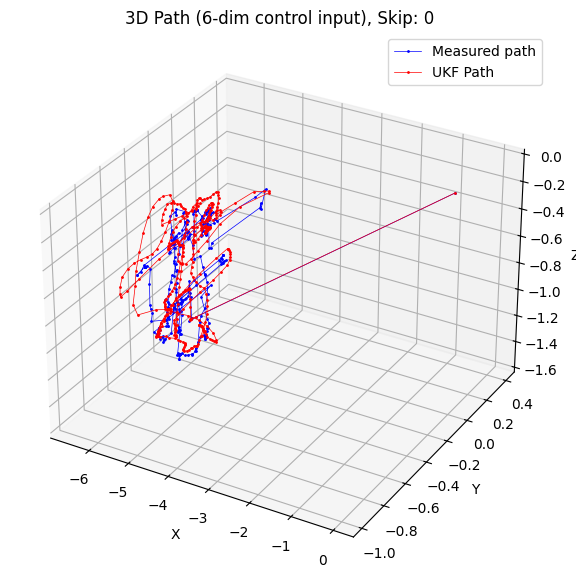

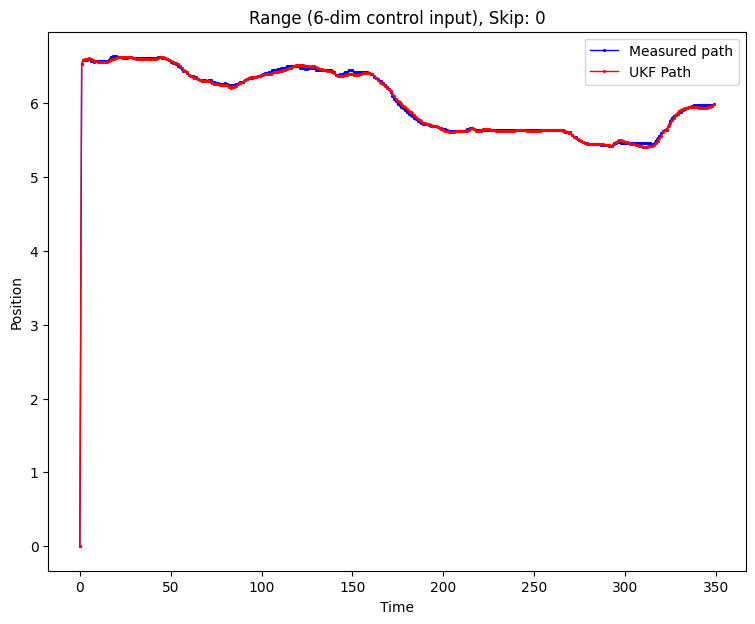

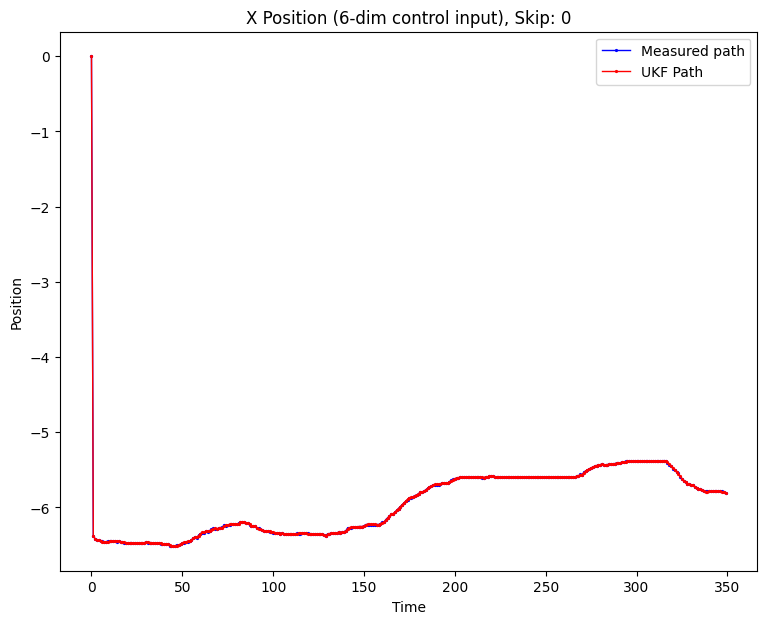

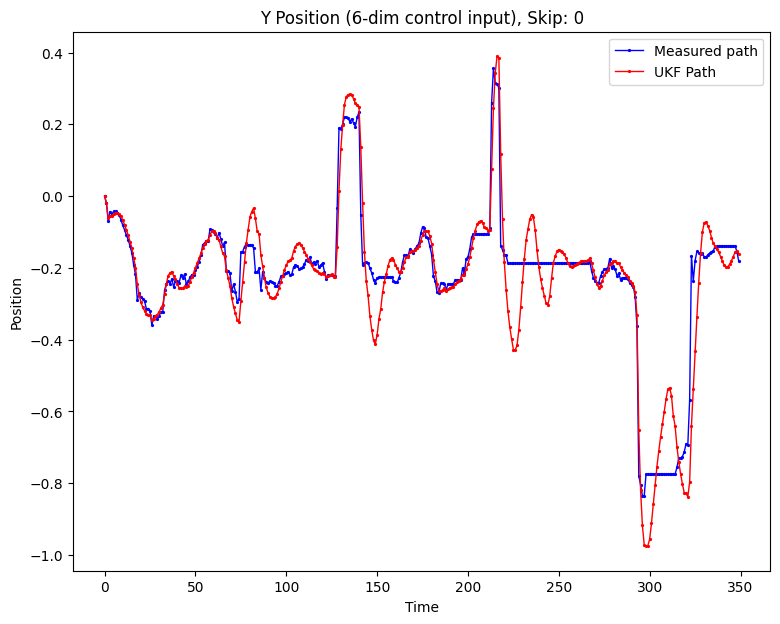

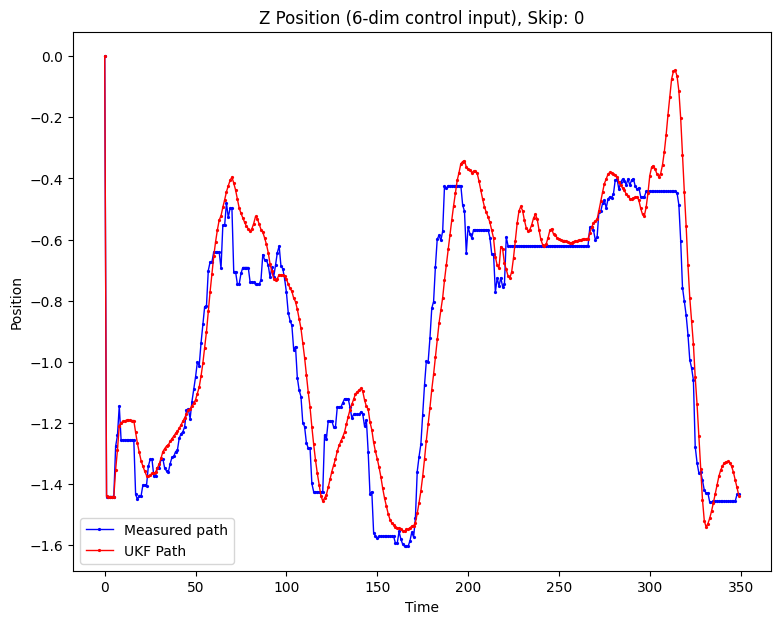

In [26]:
# get name of files in directory
path = "../3D_Position_with_IMU_measurements/"
files = [
    'rotate_and_moving_imu_measurement.txt',
    'rotate2_imu_measurement.txt',
    'movingCircle_imu_measurement.txt',
    'stational_imu_measurement.txt',
    'movingY_imu_measurement.txt',
    'movingX_imu_measurement.txt',
    'rotate_imu_measurement.txt',
    'rotate_and_moving2_imu_measurement.txt'
]

index = 7
with open(path + files[index], 'r') as file:
    print("Reading file: ", files[index])
    file.readline()
    lines = file.readlines()

#-----------------Calibration-----------------#

# In NED global frame
# Need to find initial
#   1. Position
#   2. Quaternion
#   3. Magnetic field
line = lines[0].strip().split("/")
time, x, y, z, ax, ay, az, wx, wy, wz, mx, my, mz = list(map(float, line))

# Find initial quaternion
init_quat = quater_helper.initial_quaternion(
    accel=np.array([ax, ay, az]),
    mag=np.array([mx, my, mz])
)
print("Initial Quaternion: ", init_quat)
R0 = quater_helper.quat_to_rot(init_quat)

# Find initial magnetic field, and normalize
init_mag = R0 @ np.array([mx, my, mz])
init_mag /= np.linalg.norm(init_mag)

#-----------------Calibration End-----------------#

# Variables setup
dim_x = 10
dim_z = 9
dt = 0.04972751737874981
prev_time = time

P0_scaler = 0.2
z_std = 0.04
Q0_scaler = 0.2

mag_std = 0.1
acc_std = 0.03
quat_std = 0.6

#-----------------Calibrated Variances-----------------#

ax_var = 0.0016658880362581737
ay_var = 0.0014447859371344522
az_var = 0.0018314734365366685

wx_var = 3.4186534199823104e-05
wy_var = 2.1289448355532706e-05
wz_var = 2.09939873262611e-05

# wx_var = 0.001958710398893773
# wy_var = 0.0012191127947227133
# wz_var = 0.0012058519896844583

x_measurement_var = 3.5140257117854756e-06
y_measurement_var = 0.00011835920792969562
z_measurement_var = 0.0012443314179301729 / 6

mx_var = 0.43205725237431103
my_var = 0.5172368921273852
mz_var = 0.36627446633534255

ukf = UKF(
    dim_x=dim_x, 
    dim_z=dim_z, 
    dt=dt, 
    hx=hx,
    fx=fx,
    points=MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2., kappa=-7)
)

# ukf.x = np.array([0, 0, 0, 0, 0, 0, *init_quat])
ukf.x = np.array([-y, 0, -x, 0, -z, 0, *init_quat])
print("Initial state: ", ukf.x)
ukf.P *= P0_scaler

# Measurement noise
ukf.R = np.diag([
    x_measurement_var, 
    y_measurement_var, 
    z_measurement_var, 
    mx_var, 
    my_var, 
    mz_var,
    ax_var,
    ay_var,
    az_var,
])

# Control input noise
# ukf.Q = get_Q_noise(dt, Q0_scaler, quat_std**2)

# 6x6 matrix for gyro and acceleration
Q0 = np.array([
    [wx_var, 0, 0, 0, 0, 0],
    [0, wy_var, 0, 0, 0, 0],
    [0, 0, wz_var, 0, 0, 0],
    [0, 0, 0, ax_var, 0, 0],
    [0, 0, 0, 0, ay_var, 0],
    [0, 0, 0, 0, 0, az_var],
])
ukf.Q = get_Q_noise_calibrated(dt, Q0, init_quat)

#-----------------Calibrated Variances End-----------------#

measurement_coords = [[-y], [-x], [-z]]
predicted_coords = [[-y], [-x], [-z]]

ranges_measured = [math.sqrt(x**2 + y**2 + z**2)]
ranges_predicted = [math.sqrt(x**2 + y**2 + z**2)]
count_limit = 0
count = count_limit
loops = 0
for line in lines[1: ]:
    line = line.strip().split("/")
    time, x, y, z, ax, ay, az, wx, wy, wz, mx, my, mz = list(map(float, line))

    # Convert to NED global frame
    x, y, z = -y, -x, -z

    # Save the measurement coordinates
    measurement_coords[0].append(x)
    measurement_coords[1].append(y)
    measurement_coords[2].append(z)
    ranges_measured.append(math.sqrt(x**2 + y**2 + z**2))

    # calculate time passed
    dt = time - prev_time
    prev_time = time

    # convert from degrees to radians
    wx, wy, wz = (
        math.radians(wx), 
        math.radians(wy), 
        math.radians(wz)
    )
    u = np.array([wx, wy, wz, ax, ay, az])

    # Q noise calibration for dynamc motion
    wx_cal_var = 0.0003*(wx ** 4) + 0.0005*(wx ** 3) + 0.0003*(wx ** 2) + wx_var
    wy_cal_var = 0.0003*(wy ** 4) + 0.0005*(wy ** 3) + 0.0003*(wy ** 2) + wy_var
    wz_cal_var = 0.0003*(wz ** 4) + 0.0005*(wz ** 3) + 0.0003*(wz ** 2) + wz_var
    Q0 = np.array([
        [wx_cal_var, 0, 0, 0, 0, 0],
        [0, wy_cal_var, 0, 0, 0, 0],
        [0, 0, wz_cal_var, 0, 0, 0],
        [0, 0, 0, ax_var, 0, 0],
        [0, 0, 0, 0, ay_var, 0],
        [0, 0, 0, 0, 0, az_var],
    ])
    ukf.Q = get_Q_noise_calibrated(dt, Q0, ukf.x[-4: ])

    ukf.predict(
        dt=dt,
        UT=None,
        fx=fx,
        u=u
    )

    # Normalize the magnetic field and acceleration
    # for update step comparison
    mag_z = np.array([mx, my, mz])
    mag_z /= np.linalg.norm(mag_z)

    acc_z = np.array([ax, ay, az])
    acc_z_norm = np.linalg.norm(acc_z)
    acc_z_update_ref = acc_z.copy()
    acc_z /= acc_z_norm

    # Measurement vector
    if count >= count_limit:
        count = 0
        z = np.array([x, y, z, *mag_z, *acc_z])
        ukf.update(
            z=z,
            R=None,
            UT=None,
            hx=hx,
            acc=acc_z_update_ref,
            init_mag=init_mag
        )
    else:
        count += 1

    loops += 1

    # Save the predicted coordinates
    x, _, y, _, z, *_ = ukf.x
    predicted_coords[0].append(x)
    predicted_coords[1].append(y)
    predicted_coords[2].append(z)
    ranges_predicted.append(math.sqrt(x**2 + y**2 + z**2))

    if len(predicted_coords[0]) >= 350:
        break

plot_path(
    measurement_coords[0], 
    measurement_coords[1], 
    measurement_coords[2], 
    predicted_coords[0], 
    predicted_coords[1], 
    predicted_coords[2],
    title=f'3D Path (6-dim control input), Skip: {count_limit}'
)

plot_1d_path(
    ranges_measured, 
    ranges_predicted, 
    title=f'Range (6-dim control input), Skip: {count_limit}'
)

plot_1d_path(
    measurement_coords[0], 
    predicted_coords[0], 
    title=f'X Position (6-dim control input), Skip: {count_limit}'
)

plot_1d_path(
    measurement_coords[1], 
    predicted_coords[1], 
    title=f'Y Position (6-dim control input), Skip: {count_limit}'
)

plot_1d_path(
    measurement_coords[2], 
    predicted_coords[2], 
    title=f'Z Position (6-dim control input), Skip: {count_limit}'
)

### Finding control input variances
- Using "'stational_imu_measurement.txt'" data

Opening file:  stational_imu_measurement.txt
x Var: 3.5140257117854756e-06
y Var: 0.00011835920792969562
z Var: 0.0012443314179301729
ax Var: 0.0016708369031364536
ay Var: 0.0014491712782118047
az Var: 0.0018356423366216966
wx Var: 0.11222583914499913
wy Var: 0.06985001788801017
wz Var: 0.06909022972637234
mx Var: 0.42958375480439925
my Var: 0.5100024243195852
mz Var: 0.36701111145961435


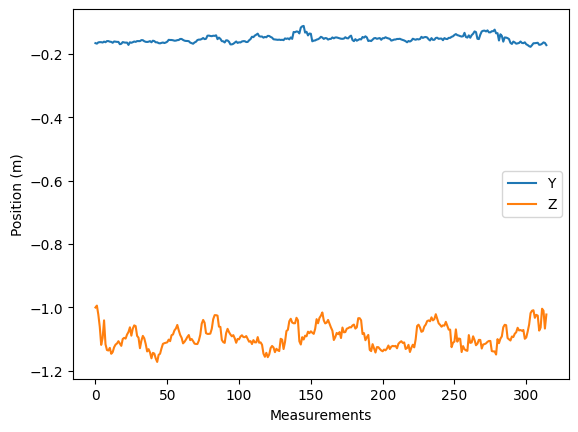

In [18]:
# get name of files in directory
path = "../3D_Position_with_IMU_measurements/"
files = [
    'rotate_and_moving_imu_measurement.txt',
    'rotate2_imu_measurement.txt',
    'movingCircle_imu_measurement.txt',
    'stational_imu_measurement.txt',
    'movingY_imu_measurement.txt',
    'movingX_imu_measurement.txt',
    'rotate_imu_measurement.txt',
    'rotate_and_moving2_imu_measurement.txt'
]

# check number of lines in file
# mean dt
dt = 0.04972751737874981

times = []
coordinates = [[], [], []]
dist = []
# for txt_file in files:
index = 3
txt_file = files[index]
print("Opening file: ", txt_file)

names = ["x", "y", "z", "ax", "ay", "az", "wx", "wy", "wz", "mx", "my", "mz"]
collections = [[] for _ in range(len(names))]
to_plot = []
with open(path + txt_file) as f:
    f.readline()
    f.readline()
    f.readline()
    for line in f:
        line = line.strip().split("/")
        time, x, y, z, ax, ay, az, wx, wy, wz, mx, my, mz = list(map(float, line))

        # wx, wy, wz = (math.radians(wx), math.radians(wy), math.radians(wz))
        x, y, z = -y, -x, -z

        for i, val in enumerate([x, y, z, ax, ay, az, wx, wy, wz, mx, my, mz]):
            collections[i].append(val)

for i, name in enumerate(names):
    print(f"{name} Var: {np.var(np.array(collections[i]))}")

# plt.plot(collections[0], label='X')
plt.plot(collections[1], label='Y')
plt.plot(collections[2], label='Z')
plt.xlabel('Measurements')
plt.ylabel('Position (m)')
plt.legend()
plt.show()



In [12]:
print(math.radians(0.11222583914499913))
print(math.radians(0.06985001788801017))
print(math.radians(0.06909022972637234))
print()

print(math.radians(0.11222583914499913) / (0.11222583914499913 * 0.0003046))
print(math.radians(0.06985001788801017) / (0.06985001788801017 * 0.0003046))
print(math.radians(0.06909022972637234) / (0.06909022972637234 * 0.0003046))
print()

print(0.001958710398893773 / 3.4186534199823104e-05)
print(0.0012191127947227133 / 2.1289448355532706e-05)
print(0.0012058519896844583 / 2.09939873262611e-05)

print((math.pi / 180) ** 2)



0.001958710398893773
0.0012191127947227133
0.0012058519896844583

57.299056204672674
57.29905620467268
57.29905620467268

57.29479295692712
57.26370990753689
57.43796883101258
0.00030461741978670857


In [170]:
0.001958710398893773 / 3.4186534199823104e-05

57.29479295692712

In [165]:
test = np.array([0.01, 0.01, 0.99]) * g
np.linalg.norm(test)



np.float64(9.712890858544638)

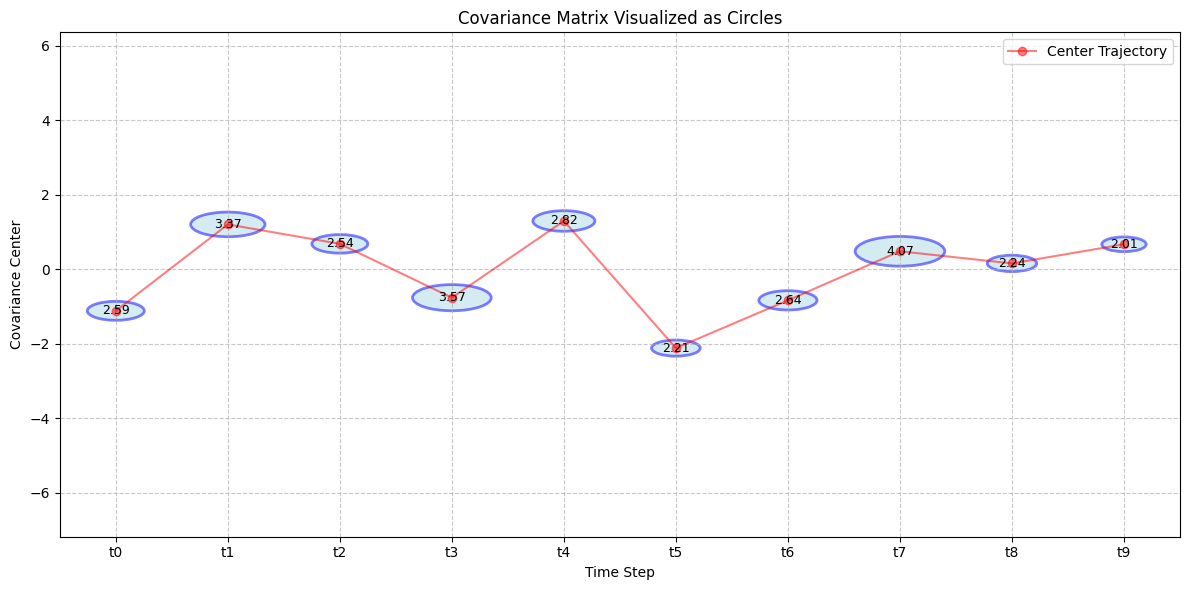

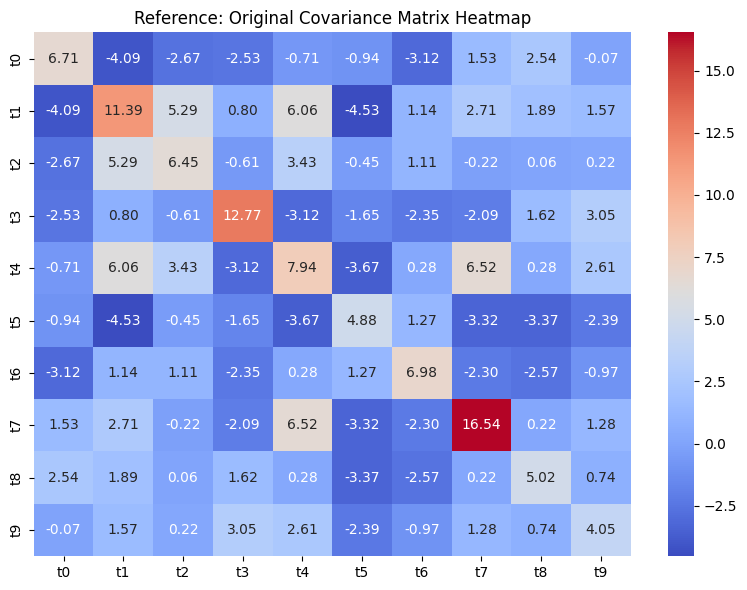

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Generate a sample 10x10 covariance matrix (symmetric positive definite)
np.random.seed(42)
A = np.random.randn(10, 10)
cov_matrix = np.dot(A, A.T)

# Time points (x-axis)
time_points = np.arange(10)

# Function to extract diagonal elements (variances) for circle radii
def get_circle_sizes(matrix):
    # Using the diagonal elements (variances) as a measure of "size"
    # You could also use other metrics like determinant or trace
    return np.sqrt(np.abs(np.diag(matrix)))  # Square root for better visualization

# Function to get off-diagonal elements as a measure for circle centers
def get_circle_centers(matrix):
    # Using the average of off-diagonal elements in each row as y-position
    centers = []
    for i in range(matrix.shape[0]):
        # Get all elements in row except diagonal
        row_vals = np.concatenate([matrix[i, :i], matrix[i, i+1:]])
        centers.append(np.mean(row_vals))
    return centers

# Get circle sizes and centers
circle_radii = get_circle_sizes(cov_matrix)
circle_centers = get_circle_centers(cov_matrix)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot circles for each time point
for i, (time, radius, center) in enumerate(zip(time_points, circle_radii, circle_centers)):
    # Normalize to make the visual more appealing
    normalized_radius = radius / np.max(circle_radii) * 0.4  # Scale factor for better visualization
    circle = Circle((time, center), normalized_radius, alpha=0.5, 
                    edgecolor='blue', facecolor='lightblue', linewidth=2)
    ax.add_patch(circle)
    
    # Add text label showing the actual covariance value
    ax.text(time, center, f"{radius:.2f}", ha='center', va='center', fontsize=9)

# Add reference lines connecting circle centers
ax.plot(time_points, circle_centers, 'ro-', alpha=0.5, label='Center Trajectory')

# Set plot limits with some padding
padding = 1
x_min, x_max = -0.5, len(time_points) - 0.5
y_min = min(circle_centers) - max(circle_radii) - padding
y_max = max(circle_centers) + max(circle_radii) + padding

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add grid, labels, and title
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Covariance Center')
ax.set_title('Covariance Matrix Visualized as Circles')
ax.legend()

# Add x-ticks for time points
ax.set_xticks(time_points)
ax.set_xticklabels([f't{i}' for i in time_points])

# Show the plot
plt.tight_layout()
plt.show()
